# Adversarial Attacks Example in PyTorch

## Import Dependencies

This section imports all necessary libraries, such as PyTorch.

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import math

import torch.backends.cudnn as cudnn
import os
import argparse

### GPU Check

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
  print("Using GPU.")
else: 
  print("Using CPU.")

Using CPU.


## Data Preparation

In [5]:
# MNIST dataloader declaration

print('==> Preparing data..')

# The standard output of the torchvision MNIST data set is [0,1] range, which
# is what we want for later processing. All we need for a transform, is to 
# translate it to tensors.

# We first download the train and test datasets if necessary and then load them into pytorch dataloaders.
mnist_train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)


mnist_dataset_sizes = {'train' : mnist_train_dataset.__len__(), 'test' : mnist_test_dataset.__len__()} # a dictionary to keep both train and test datasets

mnist_train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_train_dataset,
                 batch_size=256,
                 shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(
                dataset=mnist_test_dataset,
                batch_size=1,
                shuffle=True)

mnist_dataloaders = {'train' : mnist_train_loader ,'test' : mnist_test_loader}  # a dictionary to keep both train and test loaders

0it [00:00, ?it/s]

==> Preparing data..


 99%|█████████▉| 9846784/9912422 [00:12<00:00, 991239.70it/s] 

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



0it [00:00, ?it/s]


  0%|          | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 49214.56it/s]                           

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



 91%|█████████▏| 1507328/1648877 [00:04<00:00, 508384.49it/s]
1654784it [00:04, 331842.22it/s]                             

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



8192it [00:00, 17854.49it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [6]:
# CIFAR10 dataloader declaration

print('==> Preparing data..')

# The standard output of the torchvision CIFAR data set is [0,1] range, which
# is what we want for later processing. All we need for a transform, is to 
# translate it to tensors.

# we first download the train and test datasets if necessary and then load them into pytorch dataloaders
cifar_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar_train_loader = torch.utils.data.DataLoader(cifar_train_dataset, batch_size=128, shuffle=True, num_workers=2)

cifar_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
cifar_test_loader = torch.utils.data.DataLoader(cifar_test_dataset, batch_size=100, shuffle=False, num_workers=2)

# these are the output categories from the CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


0it [00:00, ?it/s]

==> Preparing data..



  1%|          | 1679360/170498071 [00:06<10:05, 278618.05it/s]
9920512it [00:30, 991239.70it/s]                             s]
  5%|▌         | 8544256/170498071 [00:28<07:39, 352560.68it/s]


 21%|██        | 36003840/170498071 [00:51<02:52, 778719.76it/s]


 29%|██▊       | 48930816/170498071 [01:20<14:58, 135374.54it/s]


 34%|███▎      | 57139200/170498071 [02:05<09:34, 197413.49it/s]


 41%|████      | 69279744/170498071 [02:37<07:05, 238027.16it/s]


 46%|████▌     | 78094336/170498071 [03:17<13:11, 116805.29it/s]


 51%|█████     | 86548480/170498071 [03:50<05:06, 274181.99it/s]


 56%|█████▌    | 95543296/170498071 [04:23<06:08, 203375.18it/s]


 63%|██████▎   | 107667456/170498071 [04:47<02:44, 381900.38it/s]


 69%|██████▉   | 117473280/170498071 [05:13<02:03, 428259.05it/s]


 73%|███████▎  | 125247488/170498071 [05:38<03:02, 247536.44it/s]


 77%|███████▋  | 132112384/170498071 [06:04<02:21, 272013.70it/s]


 82%|████████▏ | 140173312/170498071 [06:29<02:23, 210996.34it/s]


 87%|████████▋ | 147513344/170498071 [06:52<00:49, 462722.39it/s]


 91%|█████████ | 154411008/170498071 [07:16<01:22, 194469.51it/s]


 94%|█████████▍| 160931840/170498071 [07:45<00:42, 224978.72it/s]


100%|█████████▉| 170491904/170498071 [08:06<00:00, 267040.80it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Model Definition

We used LeNet model to train against MNIST dataset because the dataset is not very complex and LeNet can easily reach a high accuracy to then demonstrate an ttack. For CIFAR10 dataset, however, we used the more complex DenseNet model to reach an accuracy of 90% to then attack.

### LeNet

In [7]:
# LeNet Model definition
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  #first convolutional layer
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #secon convolutional layer with dropout
        x = x.view(-1, 320)   #making the data flat
        x = F.relu(self.fc1(x)) #fully connected layer
        x = F.dropout(x, training=self.training) #final dropout
        x = self.fc2(x) # last fully connected layer
        return F.log_softmax(x, dim=1) #output layer

This is the standard implementation of the DenseNet proposed in the following paper.
[DenseNet paper](https://arxiv.org/abs/1608.06993)

The idea of Densely Connected Networks is that every layer is connected to all its previous layers and its succeeding ones, thus forming a Dense Block.

![alt text](https://cdn-images-1.medium.com/freeze/max/1000/1*04TJTANujOsauo3foe0zbw.jpeg?q=20)

The implementation is broken to smaller parts, called a Dense Block with 5 layers. Each time there is a convolution operation of the previous layer, it is followed by concatenation of the tensors. This is allowed as the channel dimensions, height and width of the input stay the same after convolution with a kernel size 3×3 and padding 1.
In this way the feature maps produced are more diversified and tend to have richer patterns. Also, another advantage is better information flow during training.

### DenseNet

In [8]:
# This is a basic densenet model definition.

class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# This creates a densenet model with basic settings for cifar.
def densenet_cifar():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)

In [7]:
#building model for MNIST data
print('==> Building the model for MNIST dataset..')
mnist_model = LeNet().to(device)
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)
mnist_num_epochs= 20

==> Building the model for MNIST dataset..


In [8]:
#building model for CIFAR10
# Model
print('==> Building the model for CIFAR10 dataset..')

# initialize our datamodel
cifar_model = densenet_cifar()
cifar_model = cifar_model.to(device)


# use cross entropy as our objective function, since we are building a classifier
cifar_criterion = nn.CrossEntropyLoss()

# use adam as an optimizer, because it is a popular default nowadays
# (following the crowd, I know)
cifar_optimizer = optim.Adam(cifar_model.parameters(), lr=0.1)
best_acc = 0  # save the best test accuracy
start_epoch = 0  # start from epoch 0
cifar_num_epochs =20

==> Building the model for CIFAR10 dataset..


##Model Training

In [0]:
#Training for MNIST dataset
def train_mnist_model(model, data_loaders, dataset_sizes, criterion, optimizer, num_epochs, device):
    
    model = model.to(device)
    model.train() # set train mode
    
        
  
    # for each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        running_loss, running_corrects = 0.0, 0
        
        # for each batch
        for inputs, labels in data_loaders['train']:
            inputs = inputs.to(device)
            labels =labels.to(device)  

            
    
            # making sure all the gradients of parameter tensors are zero
            optimizer.zero_grad() # set gradient as 0
            
            # get the model output
            outputs = model(inputs)
            
            # get the prediction of model
            _, preds = torch.max(outputs, 1)
            
            # calculate loss of the output
            loss = criterion(outputs, labels)
            
            # backpropagation
            loss.backward()
            
            # update model parameters using optimzier
            optimizer.step()
            
            
            batch_loss_total = loss.item() * inputs.size(0) # total loss of the batch
            running_loss += batch_loss_total # cumluative sum of loss
            running_corrects += torch.sum(preds == labels.data) # cumulative sum of correct count
        
        #calculating the loss and accuracy for the epoch   
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print('-' * 10)
        
    
    # after tranining epochs, test epoch starts
    else:
        model.eval() # set test mode
        running_loss, running_corrects = 0.0, 0
        
        # for each batch
        for inputs, labels in data_loaders['test']:
            inputs = inputs.to(device)
            labels =labels.to(device)

    
            # same with the training part.
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
                    
            
            running_loss += loss.item() * inputs.size(0) # cumluative sum of loss
            running_corrects += torch.sum(preds == labels.data) # cumluative sum of corrects count
         
        #calculating the loss and accuracy
        test_loss = running_loss / dataset_sizes['test']
        test_acc = (running_corrects.double() / dataset_sizes['test']).item()
        print('<Test Loss: {:.4f} Acc: {:.4f}>'.format(test_loss, test_acc))
        

In [14]:
train_mnist_model(mnist_model, mnist_dataloaders, mnist_dataset_sizes, mnist_criterion, mnist_optimizer, mnist_num_epochs, device)

Epoch 1/20
Train Loss: 0.1181 Acc: 0.9653
----------
Epoch 2/20
Train Loss: 0.1189 Acc: 0.9658
----------
Epoch 3/20
Train Loss: 0.1157 Acc: 0.9658
----------
Epoch 4/20
Train Loss: 0.1159 Acc: 0.9655
----------
Epoch 5/20
Train Loss: 0.1130 Acc: 0.9665
----------
Epoch 6/20
Train Loss: 0.1108 Acc: 0.9676
----------
Epoch 7/20
Train Loss: 0.1104 Acc: 0.9680
----------
Epoch 8/20
Train Loss: 0.1100 Acc: 0.9674
----------
Epoch 9/20
Train Loss: 0.1039 Acc: 0.9688
----------
Epoch 10/20
Train Loss: 0.1064 Acc: 0.9697
----------
Epoch 11/20
Train Loss: 0.1045 Acc: 0.9688
----------
Epoch 12/20
Train Loss: 0.1041 Acc: 0.9693
----------
Epoch 13/20
Train Loss: 0.1047 Acc: 0.9693
----------
Epoch 14/20
Train Loss: 0.1023 Acc: 0.9695
----------
Epoch 15/20
Train Loss: 0.1003 Acc: 0.9708
----------
Epoch 16/20
Train Loss: 0.1008 Acc: 0.9703
----------
Epoch 17/20
Train Loss: 0.0976 Acc: 0.9711
----------
Epoch 18/20
Train Loss: 0.0960 Acc: 0.9714
----------
Epoch 19/20
Train Loss: 0.0946 Acc: 0

In [0]:
# Training for CIFAR10 dataset
def train_cifar_model(model, train_loader, criterion, optimizer, num_epochs, device):
    
    print('\nEpoch: %d' % num_epochs)
    model.train() #set the mode to train
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # making sure all the gradients of parameter tensors are zero
        outputs = model(inputs) #forward pass the model againt the input
        loss = criterion(outputs, targets) #calculate the loss
        loss.backward() #back propagation
        optimizer.step() #update model parameters using the optimiser

        train_loss += loss.item() #cumulative sum of loss
        _, predicted = outputs.max(1) #the model prediction
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item() #cumulative sume of corrects count
        if batch_idx % 100 == 0:
          #calculating and printig the loss and accuracy
          print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

#testing for CIFAR10 dataset
def test_cifar_model(model, test_loader, criterion, device, save=True):
    """Tests the model.
    Taks the epoch number as a parameter.
    """
    global best_acc
    model.eval() # set the mode to test
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        #similar to the train part
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 100 == 0:
                print('Loss: %.3f | Acc: %.3f%% (%d/%d) TEST' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    #calculating the accuracy
    acc = 100.*correct/total
    if acc > best_acc and save:
        best_acc = acc

In [34]:

for epoch in range(start_epoch, start_epoch+cifar_num_epochs):
    train_cifar_model(cifar_model, cifar_train_loader, cifar_criterion, cifar_optimizer, epoch, device)
    test_cifar_model(cifar_model, cifar_test_loader, cifar_criterion, device)


Epoch: 0
Loss: 0.251 | Acc: 90.625% (116/128)
Loss: 0.228 | Acc: 91.747% (11861/12928)
Loss: 0.237 | Acc: 91.581% (23562/25728)
Loss: 0.239 | Acc: 91.539% (35268/38528)
Loss: 0.665 | Acc: 78.000% (78/100) TEST

Epoch: 1
Loss: 0.165 | Acc: 96.875% (124/128)
Loss: 0.207 | Acc: 92.845% (12003/12928)
Loss: 0.221 | Acc: 92.269% (23739/25728)
Loss: 0.230 | Acc: 91.873% (35397/38528)
Loss: 0.467 | Acc: 87.000% (87/100) TEST

Epoch: 2
Loss: 0.224 | Acc: 90.625% (116/128)
Loss: 0.199 | Acc: 92.907% (12011/12928)
Loss: 0.218 | Acc: 92.370% (23765/25728)
Loss: 0.219 | Acc: 92.281% (35554/38528)
Loss: 0.566 | Acc: 84.000% (84/100) TEST

Epoch: 3
Loss: 0.227 | Acc: 91.406% (117/128)
Loss: 0.193 | Acc: 93.309% (12063/12928)
Loss: 0.198 | Acc: 93.148% (23965/25728)
Loss: 0.209 | Acc: 92.740% (35731/38528)
Loss: 0.487 | Acc: 84.000% (84/100) TEST

Epoch: 4
Loss: 0.114 | Acc: 97.656% (125/128)
Loss: 0.185 | Acc: 93.502% (12088/12928)
Loss: 0.195 | Acc: 93.089% (23950/25728)
Loss: 0.211 | Acc: 92.515% 

## Save and Reload the Model

In [9]:
# Mounting Google Drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

gdrive_dir = 'gdrive/My Drive/ml/'  # update with your own path

ModuleNotFoundError: No module named 'google.colab'

In [0]:
# Save and reload the  mnist_model
print('==> Saving model for MNIST..')
torch.save(mnist_model.state_dict(), gdrive_dir+'lenet_mnist_model.pth')

#change the directory to load your own pretrained model
print('==> Loading saved model for MNIST..')
mnist_model = LeNet().to(device)
mnist_model.load_state_dict(torch.load(gdrive_dir+'lenet_mnist_model.pth'))
mnist_model.eval()

In [0]:
# Save and reload the  cifar_model
print('==> Saving model for CIFAR..')
torch.save(cifar_model.state_dict(), './densenet_cifar_model.pth')

#change the directory to load your own pretrained model
print('==> Loading saved model for CIFAR..')
cifar_model = densenet_cifar().to(device)
cifar_model.load_state_dict(torch.load(gdrive_dir+'densenet_cifar_model.pth'))
cifar_model.eval()

## Attack Definition

We used these two attack methods:

* Fast Gradient Signed Method (FGSM)
* Iterative Least Likely method (Iter.L.L.)

In [0]:
# Fast Gradient Singed Method attack (FGSM)
#Model is the trained model for the target dataset
#target is the ground truth label of the image
#epsilon is the hyper parameter which shows the degree of perturbation

def fgsm_attack(model, image, target, epsilon):
    # Set requires_grad attribute of tensor. Important for Attack
    image.requires_grad = True

    # Forward pass the data through the model
    output = model(image)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability(the prediction of the model)
    
    
   
    # If the initial prediction is already wrong, dont bother attacking
    if init_pred[0].item() != target[0].item():
    #if init_pred.item() != target.item():
        return image
    # Calculate the loss
    loss = F.nll_loss(output, target)
    # Zero all existing gradients
    model.zero_grad()
    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = image.grad.data
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [0]:
# Iterative least likely method

# Model is the trained model for the target dataset
# target is the ground truth label of the image
# alpha is the hyper parameter which shows the degree of perturbation in each iteration, the value is borrowed from the refrenced paper [4] according to the report file
# iters is the no. of iterations
# no. of iterations can be set manually, otherwise (if iters==0) this function will take care of it

def ill_attack(model, image, target, epsilon, alpha, iters): 

    # Forward passing the image through model one time to get the least likely labels
    output = model(image)
    ll_label = torch.min(output, 1)[1] # get the index of the min log-probability    
    
    if iters == 0 :
        # In paper [4], min(epsilon + 4, 1.25*epsilon) is used as number of iterations
        iters = int(min(epsilon + 4, 1.25*epsilon))
    
    # In the original paper the images were in [0,255] range but here our data is in [0,1].
    # So we need to scale the epsilon value in a way that suits our data, which is dividing by 255.
    epsilon = epsilon/255
    
    for i in range(iters) : 
        # Set requires_grad attribute of tensor. Important for Attack
        image.requires_grad = True
        
        # Forward pass the data through the model
        output = model(image)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability(the model's prediction)
        
        # If the current prediction is already wrong, dont bother to continue
        if init_pred.item() != target.item():
            return image

        # Calculate the loss
        loss = F.nll_loss(output, ll_label) 

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = image.grad.data

        # Collect the element-wise sign of the data gradient
        sign_data_grad = data_grad.sign()
        # Create the perturbed image by adjusting each pixel of the input image
        perturbed_image = image - alpha*sign_data_grad
        
                
        # Updating the image for next iteration
        #
        # We want to keep the perturbed image in range [image-epsilon, image+epsilon] 
        # based on the definition of the attack. However the value of image-epsilon 
        # itself must not fall behind 0, as the data range is [0,1].
        # And the value of image+epsilon also must not exceed 1, for the same reason.
        # So we clip the perturbed image between the (image-epsilon) clipped to 0 and 
        # (image+epsilon) clipped to 1.
        a = torch.clamp(image - epsilon, min=0)  
        b = (perturbed_image>=a).float()*perturbed_image + (a>perturbed_image).float()*a
        c = (b > image+epsilon).float()*(image+epsilon) + (image+epsilon >= b).float()*b
        image = torch.clamp(c, max=1).detach_()
    
    return image

## Model Attack Design

In [ ]:
# We used the same values as described in the reference paper [4] in the report.

fgsm_epsilons = [0, .05, .1, .15, .2, .25, .3] # values for epsilon hyper-parameter for FGSM attack
ill_epsilons = [0, 2, 4, 8, 16] # values for epsilon hyper-parameter for Iter.L.L attack



170500096it [08:17, 267040.80it/s]                               

In [0]:
#This is where we test the effect of the attack on the trained model
#model is the pretrained model on your dataset
#test_loader contains the test dataset
#other parameters are set based on the type of the attack

def attack_test(model, device, test_loader, epsilon, iters, attack='fgsm', alpha=1 ):

    # Accuracy counter. accumulates the number of correctly predicted exampels
    correct = 0
    adv_examples = []  # a list to save some of the successful adversarial examples for visualizing purpose
    orig_examples = []  # this list keeps the original image before manipulation corresponding to the images in adv_examples list for comparing purpose


    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability (model prediction of the image)
       
      
        
        # Call the Attack
        if attack == 'fgsm':
            perturbed_data = fgsm_attack(model, data, target, epsilon=epsilon )
        else:
            perturbed_data = ill_attack(model, data, target, epsilon, alpha, iters)
        

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        #target refers to the ground truth label
        #init_pred refers to the model prediction of the original image
        #final_pred refers to the model prediction of the manipulated image
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability (model prediction of the perturbed image)
        if final_pred[0].item() == target[0].item():  #perturbation hasn't affected the classification
            correct += 1
            
            # Special case for saving 0 epsilon examples which is equivalent to no adversarial attack
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                orig_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred[0].item(), final_pred[0].item(), adv_ex) )
                orig_examples.append( (target[0].item(), init_pred[0].item(), orig_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                orig_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred[0].item(), final_pred[0].item(), adv_ex) )
                orig_examples.append( (target[0].item(), init_pred[0].item(), orig_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial examples and their corresponding original images
    return final_acc, adv_examples, orig_examples

##Running the Attack for MNIST dataset

In [21]:
#FGSM attack
mnist_fgsm_accuracies = []  #list to keep the model accuracy after attack for each epsilon value
mnist_fgsm_examples = []  # list to collect adversarial examples returned from the attack_test function for every epsilon values
mnist_fgsm_orig_examples = []  #list to collect original images corresponding the collected adversarial examples

# Run test for each epsilon
for eps in fgsm_epsilons:
    acc, ex, orig = attack_test(mnist_model, device, mnist_test_loader, eps, attack='fgsm', alpha=1, iters=0)
    mnist_fgsm_accuracies.append(acc)
    mnist_fgsm_examples.append(ex)
    mnist_fgsm_orig_examples.append(orig)

Epsilon: 0	Test Accuracy = 9900 / 10000 = 0.99
Epsilon: 0.05	Test Accuracy = 9375 / 10000 = 0.9375
Epsilon: 0.1	Test Accuracy = 8049 / 10000 = 0.8049
Epsilon: 0.15	Test Accuracy = 5992 / 10000 = 0.5992
Epsilon: 0.2	Test Accuracy = 4014 / 10000 = 0.4014
Epsilon: 0.25	Test Accuracy = 2601 / 10000 = 0.2601
Epsilon: 0.3	Test Accuracy = 1785 / 10000 = 0.1785


In [22]:
#Iterative_LL attack
mnist_ill_accuracies = [] #list to keep the model accuracy after attack for each epsilon value
mnist_ill_examples = []  # list to collect adversarial examples returned from the attack_test function for every epsilon values
mnist_ill_orig_examples = []  #list to collect original images corresponding the collected adversarial examples

# Run test for each epsilon
for eps in ill_epsilons:
    acc, ex, orig = attack_test(mnist_model, device, mnist_test_loader, eps, attack='ill', alpha=1, iters=0)
    mnist_ill_accuracies.append(acc)
    mnist_ill_examples.append(ex)
    mnist_ill_orig_examples.append(orig)

Epsilon: 0	Test Accuracy = 9900 / 10000 = 0.99
Epsilon: 2	Test Accuracy = 9900 / 10000 = 0.99
Epsilon: 4	Test Accuracy = 9511 / 10000 = 0.9511
Epsilon: 8	Test Accuracy = 241 / 10000 = 0.0241
Epsilon: 16	Test Accuracy = 0 / 10000 = 0.0


##Visualizing the results for MNIST dataset

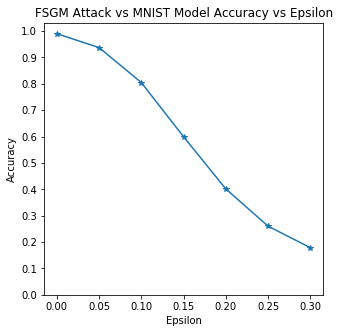

In [24]:
#Accuracy after attack vs epsilon
plt.figure(figsize=(5,5))
plt.plot(fgsm_epsilons, mnist_fgsm_accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("FSGM Attack vs MNIST Model Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

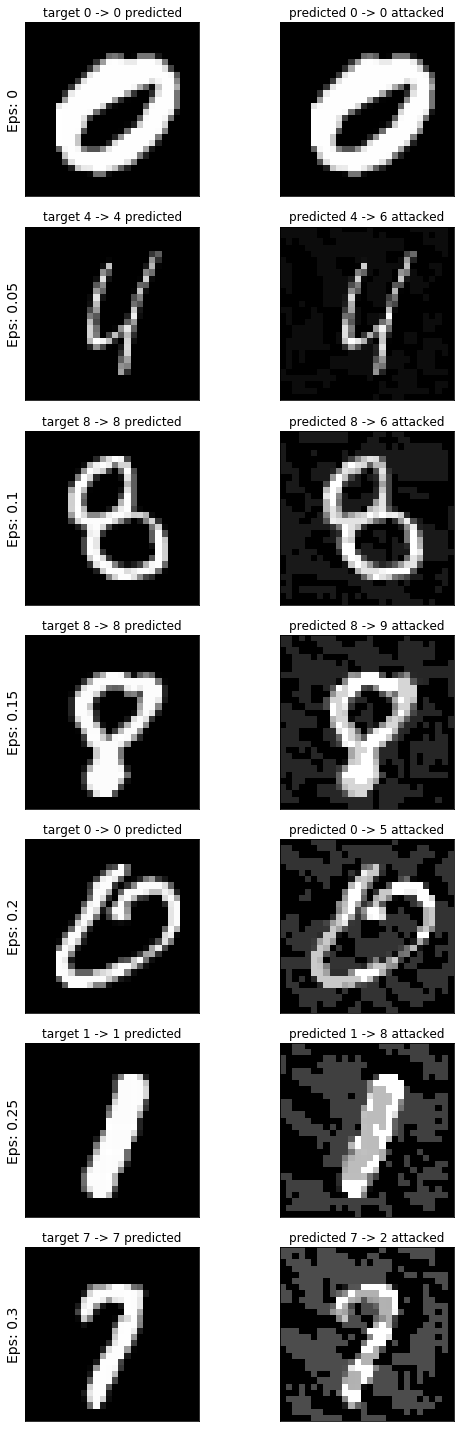

In [25]:
# Plot several examples vs their adversarial samples at each epsilon for fgms attack
cnt = 0
plt.figure(figsize=(8,20))
for i in range(len(fgsm_epsilons)):
    for j in range(2):
        cnt += 1
        plt.subplot(len(fgsm_epsilons),2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j==0:
            plt.ylabel("Eps: {}".format(fgsm_epsilons[i]), fontsize=14)
    
            orig,adv,ex = mnist_fgsm_orig_examples[i][0]
            plt.title("target "+"{} -> {}".format(orig, adv)+ " predicted")
            plt.imshow(ex, cmap="gray")
        else:
            orig,adv,ex = mnist_fgsm_examples[i][0]
            plt.title("predicted "+"{} -> {}".format(orig, adv)+ " attacked")
            plt.imshow(ex, cmap="gray")
            
plt.tight_layout()
plt.show()

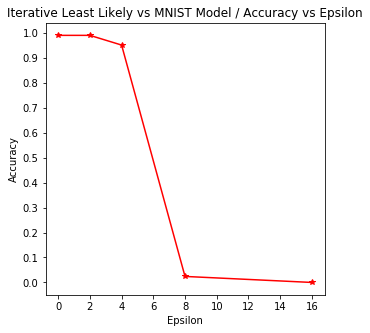

In [26]:
#Accuracy after attack vs epsilon
plt.figure(figsize=(5,5))
plt.plot(ill_epsilons, mnist_ill_accuracies, "*-", color='R')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 17, step=2))
plt.title("Iterative Least Likely vs MNIST Model / Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

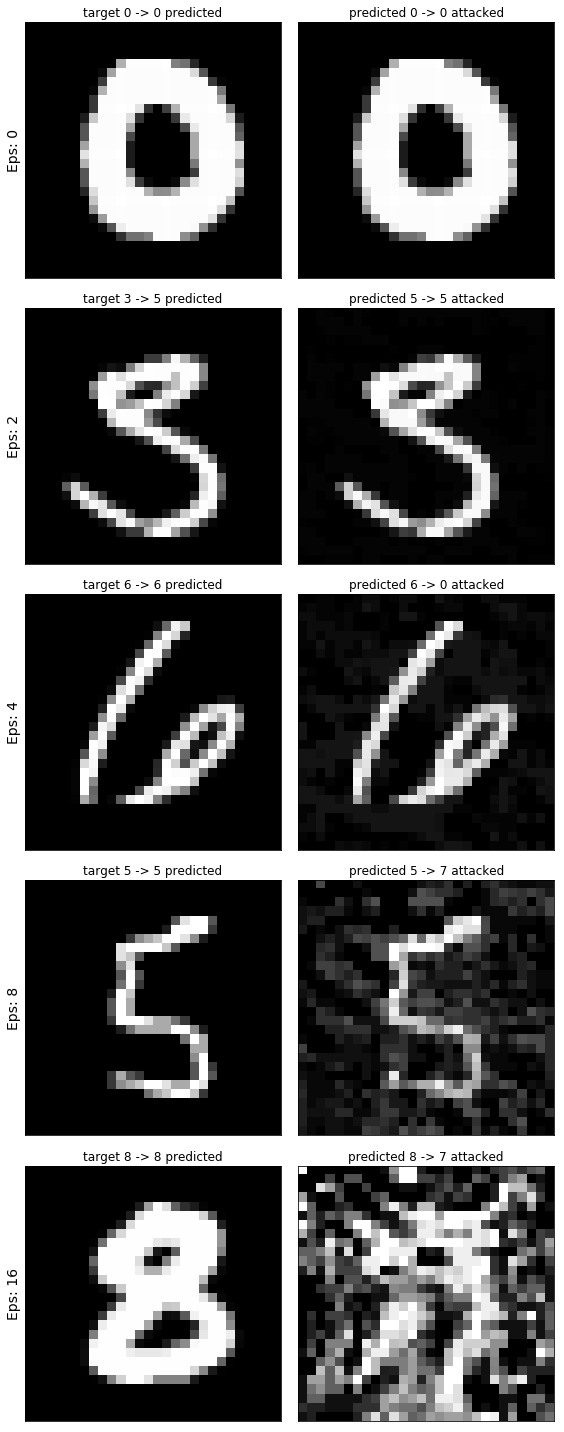

In [27]:
# Plot several examples vs their adversarial samples at each epsilon for ill attack
cnt = 0
plt.figure(figsize=(8,20))
for i in range(len(ill_epsilons)):
    for j in range(2):
        cnt += 1
        plt.subplot(len(ill_epsilons),2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j==0:
            plt.ylabel("Eps: {}".format(ill_epsilons[i]), fontsize=14)
    
            orig,adv,ex = mnist_ill_orig_examples[i][0]
            plt.title("target "+"{} -> {}".format(orig, adv)+ " predicted")
            plt.imshow(ex, cmap="gray")
        else:
            orig,adv,ex = mnist_ill_examples[i][0]
            plt.title("predicted "+"{} -> {}".format(orig, adv)+ " attacked")
            plt.imshow(ex, cmap="gray")
            
plt.tight_layout()
plt.show()

##Running the Attack for CIFAR10 dataset

In [28]:
#FGSM attack
cifar_fgsm_accuracies = [] #list to keep the model accuracy after attack for each epsilon value
cifar_fgsm_examples = [] # list to collect adversarial examples returned from the attack_test function for every epsilon values
cifar_fgsm_orig_examples = [] #list to collect original images corresponding the collected adversarial examples

# Run test for each epsilon
for eps in fgsm_epsilons:
    acc, ex, orig = attack_test(cifar_model, device, cifar_test_loader, eps, attack='fgsm', alpha=1, iters=0)
    cifar_fgsm_accuracies.append(acc)
    cifar_fgsm_examples.append(ex)
    cifar_fgsm_orig_examples.append(orig)

Epsilon: 0	Test Accuracy = 88 / 100 = 0.88
Epsilon: 0.05	Test Accuracy = 10 / 100 = 0.1
Epsilon: 0.1	Test Accuracy = 12 / 100 = 0.12
Epsilon: 0.15	Test Accuracy = 14 / 100 = 0.14
Epsilon: 0.2	Test Accuracy = 17 / 100 = 0.17
Epsilon: 0.25	Test Accuracy = 10 / 100 = 0.1
Epsilon: 0.3	Test Accuracy = 8 / 100 = 0.08


In [29]:
#Iterative_LL attack
cifar_ill_accuracies = [] #list to keep the model accuracy after attack for each epsilon value
cifar_ill_examples = [] # list to collect adversarial examples returned from the attack_test function for every epsilon values
cifar_ill_orig_examples = [] #list to collect original images corresponding the collected adversarial examples

# Run test for each epsilon
for eps in ill_epsilons:
    acc, ex, orig = attack_test(cifar_model, device, cifar_test_loader, eps, attack='ill', alpha=1, iters=0)
    cifar_ill_accuracies.append(acc)
    cifar_ill_examples.append(ex)
    cifar_ill_orig_examples.append(orig)

Epsilon: 0	Test Accuracy = 88 / 100 = 0.88
Epsilon: 2	Test Accuracy = 27 / 100 = 0.27
Epsilon: 4	Test Accuracy = 0 / 100 = 0.0
Epsilon: 8	Test Accuracy = 0 / 100 = 0.0
Epsilon: 16	Test Accuracy = 0 / 100 = 0.0


##Visualizing the results for CIFAR10  dataset

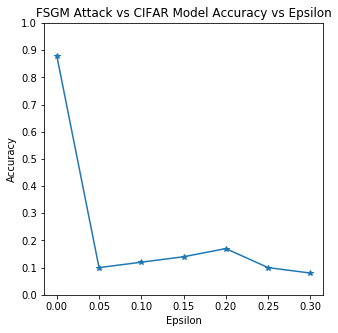

In [30]:
#Accuracy after attack vs epsilon
plt.figure(figsize=(5,5))
plt.plot(fgsm_epsilons, cifar_fgsm_accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("FSGM Attack vs CIFAR Model Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

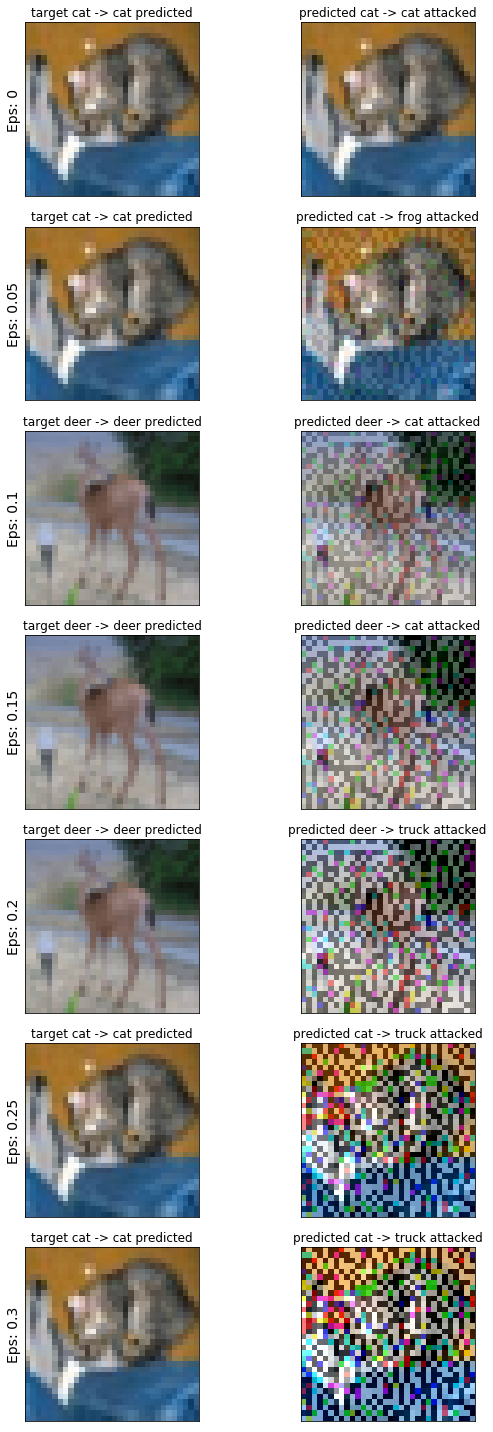

In [31]:
# Plot several examples vs their adversarial samples at each epsilon for fgms attack
cnt = 0
# 8 is the separation between images
# 20 is the size of the printed image
plt.figure(figsize=(8,20))
for i in range(len(fgsm_epsilons)):
    for j in range(2):
        cnt += 1
        plt.subplot(len(fgsm_epsilons),2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j==0:
            plt.ylabel("Eps: {}".format(fgsm_epsilons[i]), fontsize=14)
    
            orig,adv,ex = cifar_fgsm_orig_examples[i][0]
            plt.title("target "+"{} -> {}".format(classes[orig], classes[adv])+ " predicted")
            plt.imshow(ex[0].transpose(1,2,0), cmap="gray")
        else:
            orig,adv,ex = cifar_fgsm_examples[i][0]
            plt.title("predicted "+"{} -> {}".format(classes[orig], classes[adv])+ " attacked")
            plt.imshow(ex[0].transpose(1,2,0), cmap="gray")
plt.tight_layout()
plt.show()

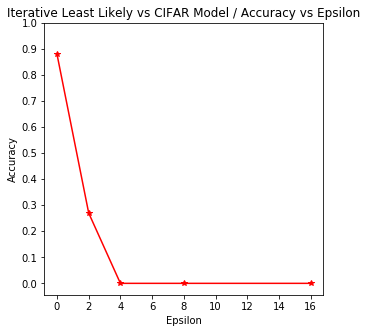

In [32]:
#Accuracy after attack vs epsilon
plt.figure(figsize=(5,5))
plt.plot(ill_epsilons, cifar_ill_accuracies, "*-", color='R')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 17, step=2))
plt.title("Iterative Least Likely vs CIFAR Model / Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

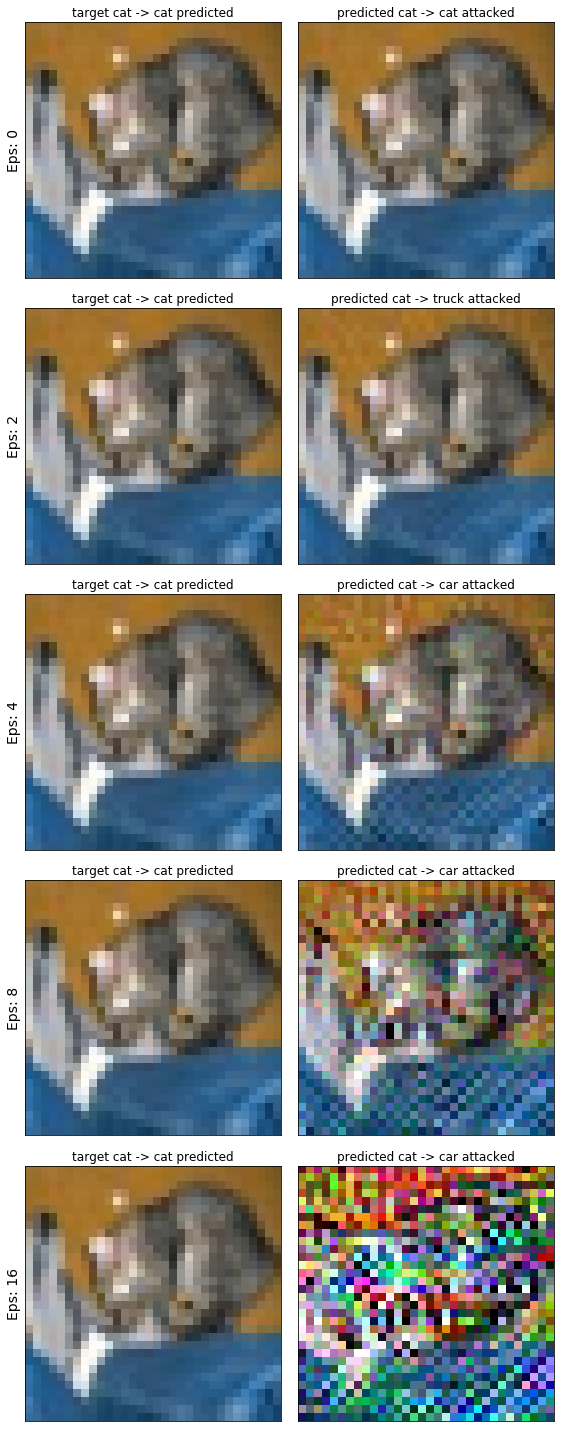

In [33]:
# Plot several examples vs their adversarial samples at each epsilon for iterative
# least likely attack.

cnt = 0
# 8 is the separation between images
# 20 is the size of the printed image
plt.figure(figsize=(8,20))
for i in range(len(ill_epsilons)):
    for j in range(2):
        cnt += 1
        plt.subplot(len(ill_epsilons),2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j==0:
            plt.ylabel("Eps: {}".format(ill_epsilons[i]), fontsize=14)
    
            orig,adv,ex = cifar_ill_orig_examples[i][0]
            plt.title("target "+"{} -> {}".format(classes[orig], classes[adv])+ " predicted")
            plt.imshow(ex[0].transpose(1,2,0), cmap="gray")
        else:
            orig,adv,ex = cifar_ill_examples[i][0]
            plt.title("predicted "+"{} -> {}".format(classes[orig], classes[adv])+ " attacked")
            plt.imshow(ex[0].transpose(1,2,0), cmap="gray")
plt.tight_layout()
plt.show()